In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import matplotlib
import matplotlib.pyplot as plt
from tifffile import imread
from glob import glob
import math
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx
from hmmlearn import hmm

sys.path.append("/home/cstansbu/.local/lib/python3.9/site-packages/")
import scipy
from scipy import interpolate
import skimage

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/woundHealing/tracks/C1.tracks.full.csv"

df = pd.read_csv(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(210377, 44)


,ID,t,x,y,z,parent,root,state,generation,dummy,...,c2_logFoldChange_prepared,c0_pval_prepared,c1_pval_prepared,c2_pval_prepared,c0_logFoldChange_processed,c1_logFoldChange_processed,c2_logFoldChange_processed,c0_pval_processed,c1_pval_processed,c2_pval_processed
0,1297,0,660.578947,431.852632,0.0,1297,1297,5,0,False,...,-3.314546,1.00000,1.0,1.0,-1.256871,0.786488,-1.190787,1.000000,1.110091e-15,1.000000e+00
1,1562,0,111.606557,287.885246,0.0,1562,1562,5,0,False,...,-0.692607,0.00001,1.0,1.0,2.599904,1.480041,1.431153,0.000006,2.866874e-11,1.789777e-07
2,1476,0,784.000000,218.627119,0.0,1476,1476,5,0,False,...,-3.323596,1.00000,1.0,1.0,-1.256871,1.504808,-1.199837,1.000000,8.529597e-12,1.000000e+00
3,532,0,887.925373,870.507463,0.0,532,532,5,0,False,...,-2.293977,1.00000,1.0,1.0,-1.256871,1.547546,-0.170217,1.000000,8.251843e-14,9.826009e-01
4,1308,0,849.211382,431.715447,0.0,1308,1308,5,0,False,...,-3.323596,1.00000,1.0,1.0,-1.256871,0.692383,-1.199837,1.000000,5.728084e-12,1.000000e+00


vectors.shape=(8733, 2)


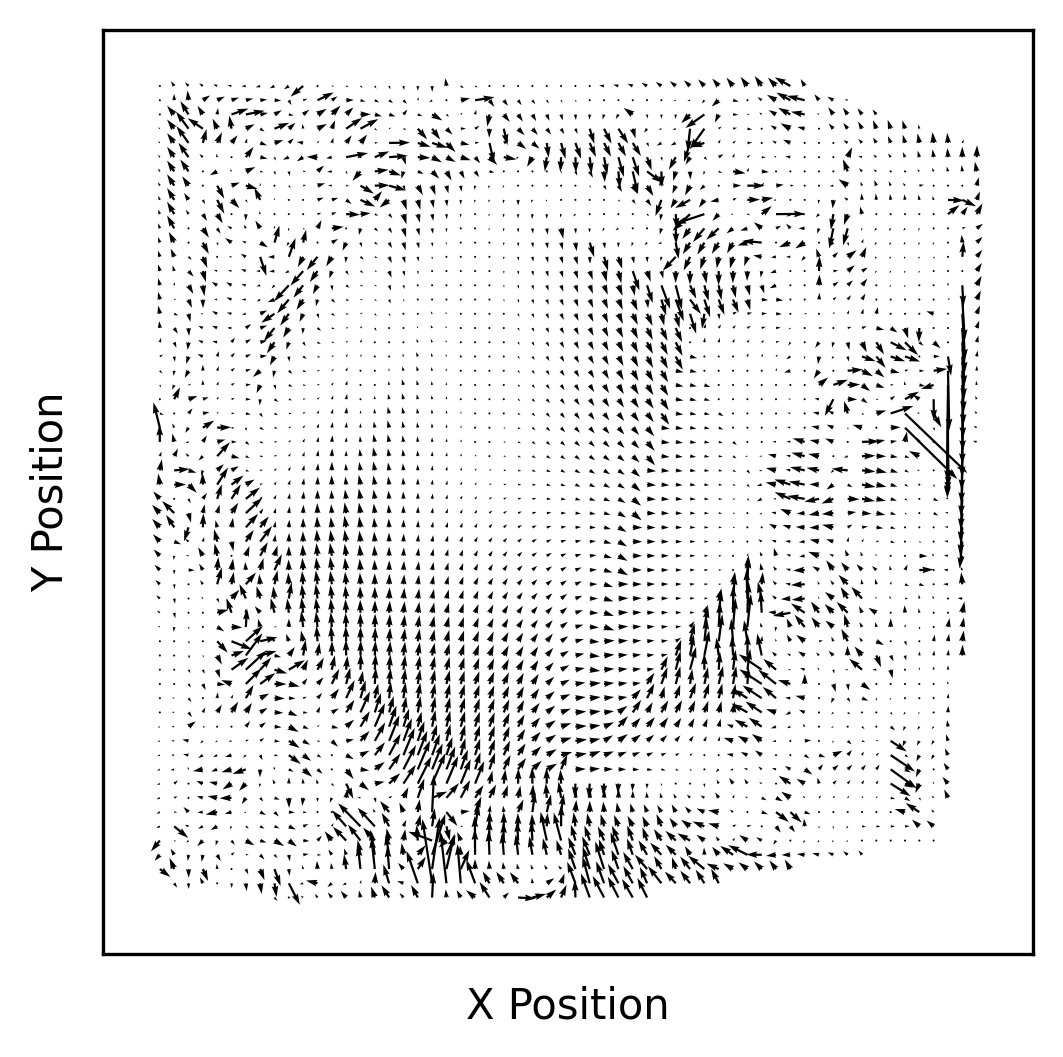

In [11]:
pdf = df.copy()

n = 60
minTrackLen = 80 # for filtering 

# filter the short tracks
pdf['trackLen'] = pdf.groupby('ID')['ID'].transform('count')
pdf = pdf[pdf['trackLen'] > minTrackLen].reset_index(drop=True)

xList = []
yList = []
vectorList = []

for tid in pdf['ID'].unique():
    vdf = pdf[pdf['ID']  == tid]
    
    x = vdf['x'].to_numpy()
    y = vdf['y'].to_numpy()
    
    vx = np.gradient(x, edge_order=2)
    vy = np.gradient(y, edge_order=2)
    
    v = np.stack([vx, vy], axis=-1)
    vectorList.append(v)
    xList.append(x)
    yList.append(y)
    
vectors = np.concatenate(vectorList)
print(f"{vectors.shape=}")
grid_x, grid_y = np.meshgrid(np.linspace(pdf['x'].min(), pdf['x'].max(), n), 
                             np.linspace(pdf['y'].min(), pdf['y'].max(), n))

grid_vectors = interpolate.griddata((np.concatenate(xList), 
                                     np.concatenate(yList)), 
                                     vectors, 
                                     (grid_x, grid_y), 
                                     method='linear')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

fig, axs = plt.subplots()

axs.quiver(grid_x, 
           grid_y, 
           grid_vectors[:,:,0], 
           grid_vectors[:,:,1],
           zorder=2)

gx = np.gradient(grid_vectors[:,:,0])
gy = np.gradient(grid_vectors[:,:,1])

gx = np.flipud(gx[0])
gy = np.flipud(gy[0])

mag = np.sqrt(gx**2 + gy**2)

# axs.imshow(mag, 
#            zorder=1, 
#            extent=(pdf['x'].min(), pdf['x'].max(), 
#                    pdf['y'].min(), pdf['y'].max()), 
#            cmap='gnuplot2',
#            alpha=0.5)

axs.set_ylabel("Y Position")
axs.set_xlabel("X Position")
_ = axs.set_xticks([])
_ = axs.set_yticks([])